# Text to SQL

- 이 노트북에서는 LLM을 사용하여 판매 데이터를 분석하기 위한 SQL 쿼리를 생성하는 방법을 보여드립니다.
- Boto3 클라이언트를 사용하여 Amazon Bedrock API와 통신하는 방법을 살펴보겠습니다.

## 0. 환경 설정

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install -r ./requirements.txt
%pip install --quiet boto3
%pip install --quiet botocore

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. 프롬프트를 이용해서 SQL Query 생성하기

#### 1-1. Simple Example

In [2]:
import boto3
import json

# Bedrock runtime 생성
bedrock_runtime = boto3.client(
    service_name="bedrock-runtime"
)

In [3]:
# SQL query 생성을 위한 프롬프트 작성
prompt = """
AnyCompany has a database with a table named sales_data containing sales records. The table has following columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Can you generate SQL queries for the below: 
- 2023년 총 매출 기준 상위 5개 베스트셀러 제품 파악하기
- 2023년 월평균 매출 계산하기
"""

In [4]:
# 사용할 모델 아이디 작성
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

# Request body 작성
request_data = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 1024,
    "temperature" : 0,
    "top_k":250,
    "top_p":0.5,
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
            ],
        }
    ],
}
request_body = json.dumps(request_data)

In [5]:
response = bedrock_runtime.invoke_model(
    body=request_body,
    modelId=model_id,
    contentType="application/json",
    accept="application/json"
)

response_body = json.loads(response['body'].read())
answer = response_body['content'][0]['text']
print(answer)

1. 2023년 총 매출 기준 상위 5개 베스트셀러 제품 파악하기

```sql
SELECT
    product_id,
    SUM(price * units_sold) AS total_revenue
FROM
    sales_data
WHERE
    date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY
    product_id
ORDER BY
    total_revenue DESC
LIMIT 5;
```

이 쿼리는 다음과 같이 동작합니다:

1. `sales_data` 테이블에서 2023년 1월 1일부터 12월 31일 사이의 레코드를 선택합니다.
2. `product_id`별로 그룹화하고, 각 제품의 총 매출(`price * units_sold`의 합계)을 계산합니다.
3. 총 매출 기준으로 내림차순 정렬합니다.
4. 상위 5개 레코드를 선택합니다.

2. 2023년 월평균 매출 계산하기

```sql
SELECT
    MONTH(date) AS month,
    ROUND(SUM(price * units_sold) / COUNT(DISTINCT date), 2) AS monthly_avg_revenue
FROM
    sales_data
WHERE
    date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY
    MONTH(date)
ORDER BY
    month;
```

이 쿼리는 다음과 같이 동작합니다:

1. `sales_data` 테이블에서 2023년 1월 1일부터 12월 31일 사이의 레코드를 선택합니다.
2. `MONTH(date)`로 월별로 그룹화합니다.
3. 각 월의 총 매출(`price * units_sold`의 합계)을 계산하고, 해당 월의 고유한 날짜 수로 나누어 월평균 매출을 계산합니다.
4. `ROUND` 함수를 사용하여 월평균 매출을 소수점 이하 2자리까지 반올림합니다.
5. 월별로 정렬합니다.

이 쿼리는 2023년 각 월의 월평균 

#### 1-2. Advanced Example

In [6]:
# SQL query 생성을 위한 프롬프트 작성
prompt_sql = """

You're provided with a database schema representing any hospital's patient management system.
The system holds records about patients, their prescriptions, doctors, and the medications prescribed.

Here's the schema:

```sql
CREATE TABLE Patients (
    PatientID int,
    FirstName varchar(50),
    LastName varchar(50),
    DateOfBirth datetime,
    Gender varchar(10),
    PRIMARY KEY (PatientID)
);

CREATE TABLE Doctors (
    DoctorID int,
    FirstName varchar(50),
    LastName varchar(50),
    Specialization varchar(50),
    PRIMARY KEY (DoctorID)
);

CREATE TABLE Prescriptions (
    PrescriptionID int,
    PatientID int,
    DoctorID int,
    DateIssued datetime,
    PRIMARY KEY (PrescriptionID)
);

CREATE TABLE Medications (
    MedicationID int,
    MedicationName varchar(50),
    Dosage varchar(50),
    PRIMARY KEY (MedicationID)
);

CREATE TABLE PrescriptionDetails (
    PrescriptionDetailID int,
    PrescriptionID int,
    MedicationID int,
    Quantity int,
    PRIMARY KEY (PrescriptionDetailID)
);
```

2023년 4월 1일에 5가지 이상의 서로 다른 약을 처방받은 모든 환자를 가져오는 SQL 쿼리를 작성하세요.
"""

In [7]:
# 사용할 모델 아이디 작성
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

# Request body 작성
request_data = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 1024,
    "temperature" : 0,
    "top_k":250,
    "top_p":0.5,
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_sql},
            ],
        }
    ],
}
request_body = json.dumps(request_data)

In [8]:
response = bedrock_runtime.invoke_model(
    body=request_body,
    modelId=model_id,
    contentType="application/json",
    accept="application/json"
)

response_body = json.loads(response['body'].read())
answer = response_body['content'][0]['text']
print(answer)

다음 SQL 쿼리를 사용하여 2023년 4월 1일에 5가지 이상의 서로 다른 약을 처방받은 모든 환자를 가져올 수 있습니다.

```sql
SELECT p.PatientID, p.FirstName, p.LastName
FROM Patients p
INNER JOIN Prescriptions pr ON p.PatientID = pr.PatientID
INNER JOIN PrescriptionDetails pd ON pr.PrescriptionID = pd.PrescriptionID
WHERE pr.DateIssued BETWEEN '2023-04-01' AND '2023-04-01 23:59:59.997'
GROUP BY p.PatientID, p.FirstName, p.LastName
HAVING COUNT(DISTINCT pd.MedicationID) >= 5;
```

이 쿼리는 다음과 같이 작동합니다:

1. `Patients` 테이블과 `Prescriptions` 테이블, `PrescriptionDetails` 테이블을 `INNER JOIN`으로 연결합니다. 이렇게 하면 환자, 처방전 및 처방 세부 정보를 모두 포함하는 결과 집합을 얻을 수 있습니다.

2. `WHERE` 절에서 `pr.DateIssued` 열을 사용하여 2023년 4월 1일에 발행된 처방전만 필터링합니다. 날짜 범위를 사용하여 전체 날짜를 포함합니다.

3. `GROUP BY` 절에서 `PatientID`, `FirstName`, `LastName`으로 그룹화하여 각 환자별로 처방 세부 정보를 그룹화합니다.

4. `HAVING` 절에서 `COUNT(DISTINCT pd.MedicationID)` 함수를 사용하여 각 환자에게 처방된 고유 약물 수를 계산합니다. 그런 다음 이 수가 5 이상인 환자만 필터링합니다.

5. `SELECT` 문에서 `PatientID`, `FirstName`, `LastName`을 반환하여 조건을 충족하는 환자의 ID와 이름을 가져옵니다.

이 쿼리는 202

## 2. LangChain 과 DB 정보를 이용해서 SQL Query 및 응답 생성하기
- 샘플 DB 는 아래 경로에서 확인할 수 있습니다.
- https://github.com/lerocha/chinook-database

#### 2-1. DB 에 연결해서 정보가져오고 SQL Query 생성하기

In [9]:
%pip install --quiet langchain==0.2.1
%pip install --quiet langchain_aws==0.1.6
%pip install --quiet langchain_community==0.2.1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
from langchain_aws import ChatBedrock
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import HumanMessage
from langchain_community.tools import QuerySQLDataBaseTool

# DB instance 생성
db = SQLDatabase.from_uri("sqlite:///db/Chinook.db")
dialect = db.dialect
table_info = db.table_info

# print("# Dialect")
# print(dialect)
# print()

# print("# Table Info")
# print(table_info)

In [11]:
# 질문
question = "직원별 총 판매액을 알려줘"

# SQL 생성을 위한 프롬프트 작성
prompt_sql = f"""

당신은 {dialect} 전문가입니다.
회사의 데이터베이스에 대한 질문을 하는 사용자와 상호 작용하고 있습니다.
아래의 데이터베이스 스키마를 기반으로 사용자의 질문에 답할 SQL 쿼리를 작성하세요.

데이터베이스 스키마는 다음과 같습니다.
<schema>
{table_info}
</schema>

SQL 쿼리만 작성하고 다른 것은 작성하지 마세요.
SQL 쿼리를 다른 텍스트로 묶지 마세요. 심지어 backtick 으로도 묶지 마세요.

예시:
Question: 10명의 고객 이름을 보여주세요.
SQL Query: SELECT Name FROM Customers LIMIT 10;

Your turn:
Question: {question}
SQL Query:
"""

In [12]:
# 필요한 파라미터 설정
model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
model_kwargs = {
    "max_tokens": 512,
    "temperature": 0,
    "top_p": 0.5,
    "top_k": 0
}

# ChatBedrock 생성
llm = ChatBedrock(
        model_id=model_id,
        model_kwargs=model_kwargs
    )

# 입력
messages = [
    HumanMessage(
        content=prompt_sql
    )
]

# 일반 방식으로 모델 호출
response = llm.invoke(messages)
sql_query = response.content
print(sql_query)

SELECT e.FirstName, e.LastName, SUM(i.Total) AS TotalSales
FROM Employee e
JOIN Customer c ON c.SupportRepId = e.EmployeeId
JOIN Invoice i ON i.CustomerId = c.CustomerId
GROUP BY e.EmployeeId;


#### 2-2. 생성한 SQL 을 이용해서 데이터 가져오기

In [13]:
from pprint import pprint

# DB 를 호출해서 가져오기
sql_result = db.run(sql_query, fetch="cursor")
sql_result_list = list(sql_result.mappings())
pprint(sql_result_list)

# DB 를 호출해서 가져오기 : langchain 에서 chain 생성을 위해 사용
execute_query = QuerySQLDataBaseTool(db=db)
sql_result_text = execute_query.invoke(sql_query)
print(sql_result_text)

[{'FirstName': 'Jane', 'LastName': 'Peacock', 'TotalSales': 833.04},
 {'FirstName': 'Margaret', 'LastName': 'Park', 'TotalSales': 775.4},
 {'FirstName': 'Steve', 'LastName': 'Johnson', 'TotalSales': 720.16}]
[('Jane', 'Peacock', 833.04), ('Margaret', 'Park', 775.4), ('Steve', 'Johnson', 720.16)]


#### 2-3 가져온 데이터 Table 로 보여주기

In [14]:
%pip install --quiet pandas
%pip install --quiet matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  FirstName LastName  TotalSales
0      Jane  Peacock      833.04
1  Margaret     Park      775.40
2     Steve  Johnson      720.16


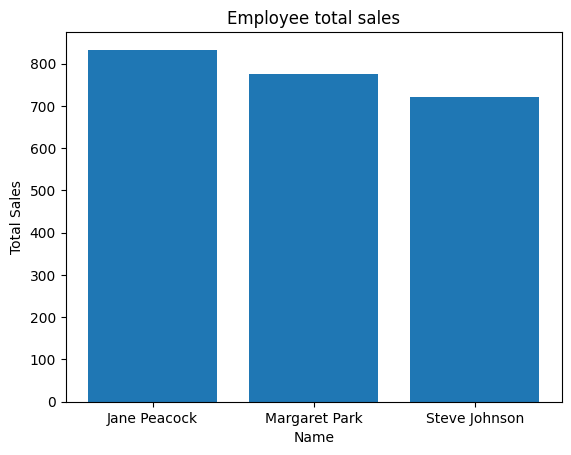

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 생성
result_df = pd.DataFrame(sql_result_list, columns=['FirstName', 'LastName', 'TotalSales'])
print(result_df)

# 그래프 출력
# 이름과 판매량 추출
names = [f"{d['FirstName']} {d['LastName']}" for d in sql_result_list]
sales = [d['TotalSales'] for d in sql_result_list]

# 바차트 그리기
plt.bar(names, sales)
plt.xlabel('Name')
plt.ylabel('Total Sales')
plt.title('Employee total sales')
plt.show()

#### 2-4 가져온 데이터로 응답 생성하기

In [22]:
# LLM 을 호출해서 자연어 응답 생성하기
answer_prompt = f"""
주어진 사용자의 질문(question) 에 대해서 SQL Query 및 SQL Result 를 참고해서 답변해주세요.
SQL Query 와 SQL Result 에 대한 설명은 하지 말고 SQL Result 에 대한 내용만 설명해주세요.
최종 답변은 읽기 편하게 정리해서 보여줘.

Question: {question}
SQL Query: {sql_query}
SQL Result: {sql_result_text}
"""

messages = [
    HumanMessage(
        content=answer_prompt
    )
]

response = llm.invoke(messages)
sql_query = response.content
print(sql_query)

직원별 총 판매액은 다음과 같습니다:

- Jane Peacock 직원의 총 판매액은 833.04달러입니다.
- Margaret Park 직원의 총 판매액은 775.4달러입니다. 
- Steve Johnson 직원의 총 판매액은 720.16달러입니다.
